# **Initialization**

## Introduction

So in this project, I'll create an AI based on the data I'm going to made from **2584** different circuit. The goal of this project is creating an AI that accelerates the process of giving an output: _optimal racing line and optimal pull-point_ of the Shell Eco-marathon vehicle. 

1.1. *The dataset details.*

Dataset created based from 35 different circuits. Then we create an augmented circuits by scalling (from x and y), flipping, and reversing the track. From 35 different race track tracing, we then proceed to smoothing the line of the track. After we get the smooth line of the track, we generate new/different dots under the lines that has been smoothed. This new dots then used to creating a new circuit segmentation. Each dots has perpendicular line that has a length as the width of the track. From the edge of each perpendicular line, we connect the edge with the perpendicular lines on the next points. Thus, we can get the track wall/barrier. We do this from **2584** different circuits that we've generated before.

After that, we use heuristic or mathematical method to generate racing line data. This racing line data also has an input and output. Previous method by Ying Xiong in 2009 uses heuristic method to determine racing line, time-lap, and energy. This energy isn't an actual energy (kinetic/potential), but he defined energy as mathematical representation that helps evaluate the efficiency of a racing line. This efficiency determined by less curvature, less curvature means less energy use. Because less curvature means less work done against centripental force.

But we do this in a diffferent approach. The purpose of this AI is to be able generate the prediction of an optimal racing lines and pull-point. Racing lines in Shell Eco-marathon vehicles should be optimal for gliding and acceleration. Unlike racing line in most sportcars like WEC or Formula one that has their powertrain on troughout the lap, Shell Eco-marathon vehicles accelerate and glide to save a lot of energy. In this research, we define the pull-point is the point of where the car have to accelerate before the glide.

Thus, we need a different kind of dataset. By learning the research from Ying Xiong, 2009, we generate the optimal racing line dataset from 2584 different circuits but with a different side data. The other data that we have in the dataset isn't only the racing line, time, and energy. The **single data** we're going to need for dataset are: acceleration of the car (`accl`), maximum vehicle glide distance (`max-gld-dist`), average speed (`avg-speed`), and some **time series data** (data we generate differently in each point or segment of the track):  time estimation (`time-est`), racing track (longitude `t-long` and latitude `t-lat`), track width (`t-width`), racing line (longitude `rl-long` and latitude `rl-lat`) and velocity (`v`). The velocity will be different on each points. Some are low, some are highs, from low to high we could analyze manually that would be where the car accelerate, otherwise from high to low will be where the car gliding. `lap` is for Lap data, it only increase when the data passes the same first row of `t-long` and `t-lat`. This tells it passes the same part of the track or the starting line. Time estimation (`time-est`) is time prediction for each points in  ss:mm:hh

By having all of this data, we can use other mathematical method to calculate some time series data for fuel consumption for on each point in the track (`fuel-cons`). So the CSV for each track will looks like this:

| `time-est` | `avg-speed` | `gld-force` | `tn-long` | `tn-lat` | `t-width` | `rl-long` | `rl-lat` | `v` | `fuel-cons` | `lap` | 

1.2. *Building The Dataset*

To building the dataset the code will work as below:
1. Input:
- **Racing track Coordinates**: Consist of track points that generated from the smoothed line. To be short, a cleaned racing track shape data. Consist of `t-long`, `t-lat`
- **Track Width** (`t-width`): How wide is the perpendicular line taken for each points on the track`t-width`.
- **Number of Laps** (`total-laps`): How many laps does the car will run?
- **Drag-Coefficient** (`vhc-drag`): The drag coefficient of the car which could affect the gliding distance.
- **Rolling Resistance Coefficient** (`vhc-roll`): Rolling resistance of the car.
- **Vehicle Mass** (`vhc-mass`): Vehicle Mass in kg.
- **Engine Power** (`vhc-power`): The power of the engine/motor of the vehicle in kW.
- **Vehicle Acceleration**  (`accl`): Acceleration variable of the car.
- **Target Estimation Total Time** (`time-total`): Target TOTAL of the estimation time. In Shell Eco-marathon, it's usually took of 35 minutes based on an average speed of approximately 25 km/h (4 laps of 3,701 m). Thus depends on the track.

2. Output:
- **Racing Line Coordinates** (`rl-long` and `rl-lat`): Coordinates of `rl-long` and `rl-lat` of the racing line for each points/segment.
- **Racing Line Smoothed Coordianates** (`tn-long` and `tn-lat`): Coordinates of `rl-long` and `rl-lat` that has been smoothed using `scipy.interpolate`
- **Energy Based on Curvature** (`E`): the integral k ds as told in Ying Xiong, 2009 research.
- **Velocity** (`v`): Vehicle velocity for each points.
- **Time Estimation** (`times-est`): Time estimation of each points on the track, the total of these should really close (less or more) to the Target Estimation Total Time `time-total`. Since we can't make it accurate with the total time anyway. Remember, too quick = too much energy.
- **Fuel Consumption**: We can compute the expected fuel consumption on each point.

By obtaining all of these data, we can start arranging the AI.

## Data Preprocessing

### Dynamics and Constraints

In [3]:
C_d = 0.1  # Drag coefficient (dimensionless)
rho = 1.225  # Air density (kg/m^3)
A = 0.5  # Frontal area (m^2)
C_r = 0.01  # Rolling resistance coefficient (dimensionless)
m = 120  # Vehicle mass (kg)
g = 9.81  # Gravitational acceleration (m/s^2)
P_engine = 2.0 * 746  # Engine power (2 HP in watts)
turn_radius = 5 # m
track_width = 0.00007

### Dynamic Gliding

1. Input:
- Drag Coefficient
- Air Density
- Frontal Area
- Rolling Resistance Coefficient
- Vehicle Mass
- Graviional acceleration

2. Output:
- Maximum Gliding Distance

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp

def deceleration(t, v, theta=0):
    # Aerodynamic drag
    F_d = 0.5 * C_d * rho * A * v**2
    # Rolling resistance
    F_r = C_r * m * g
    # Gravitational force
    F_g = m * g * np.sin(theta)
    # Total force (negative for deceleration)
    F_net = F_d + F_r + F_g
    return -F_net / m

# Simulate velocity over time
def simulate_gliding(v0, incline_angle, max_time=30):
    theta = np.radians(incline_angle)  # Convert angle to radians
    t_span = (0, max_time)
    sol = solve_ivp(deceleration, t_span, [v0], args=(theta,), dense_output=True)
    return sol.t, sol.y[0]

# Compute gliding distance
def compute_gliding_distance(v0, incline_angle):
    t, velocities = simulate_gliding(v0, incline_angle)
    distance = np.trapezoid(velocities, t)  # Integrate velocity over time
    return distance

# Example usage
v0 = 15  #(m/s)
incline_angle = 3  # Track incline in degrees

gliding_distance = compute_gliding_distance(v0, incline_angle)
print(f"Gliding distance Exapmple: {gliding_distance:.2f} meters")

### Vehicle Acceleration

a. Input
- Vehicle Mass (m)
- Aerodynamic Drag (Fd)
- Rolling Resistance (Fr)
- Gravitional Force (Fg)
- Engine Horsepower (Hp)

b. Output
- Vehicle Accceleration (`accl`)

In [ ]:
import numpy as np

def compute_acceleration(v, theta=0, P_engine=P_engine, C_d=C_d, rho=rho, A=A, C_r=C_r, m=m, g=g):
    # Aerodynamic drag
    F_d = 0.5 * C_d * rho * A * v**2
    # Rolling resistance
    F_r = C_r * m * g
    # Gravitational force
    F_g = m * g * np.sin(theta)
    # Net force from engine
    F_engine = P_engine / v if v > 0 else 0  # Prevent division by zero
    # Net acceleration
    F_net = F_engine - (F_d + F_r + F_g)
    return F_net / m

# Example usage
velocity = 5  # Current velocity in m/s
incline_angle = np.radians(5)  # Incline in degrees

acceleration = compute_acceleration(velocity, incline_angle)
print(f"Acceleration: {acceleration:.2f} m/s^2")


### Preparing The Track

#### _2.3.1 Exporting KML to CSV_

1. Input: KML file from the Google Earth that contains traced path of the track middle points.
2. Output: Coordinates  in csv format.

**For LineString**

In [ ]:
import xml.etree.ElementTree as ET  
import csv  
  
def parse_kml_to_csv(kml_file_path, csv_file_path, placemark_id):  
    # Parse the KML file  
    tree = ET.parse(kml_file_path)  
    root = tree.getroot()  
  
    # Define the namespace used in the KML file  
    namespace = {'kml': 'http://www.opengis.net/kml/2.2'}  
  
    # Find the specific Placemark element by ID  
    placemark_element = root.find(f".//kml:Placemark[@id='{placemark_id}']", namespace)  
    if placemark_element is None:  
        print(f"No Placemark with ID '{placemark_id}' found in the KML file.")  
        return  
  
    # Find the LineString element within the specified Placemark  
    coordinates_element = placemark_element.find('.//kml:LineString/kml:coordinates', namespace)  
    if coordinates_element is None:  
        print(f"No LineString coordinates found in Placemark with ID '{placemark_id}'.")  
        return  
  
    # Get the text content of the coordinates element  
    coordinates_text = coordinates_element.text.strip()  
  
    # Split the coordinates string by spaces to get individual coordinate sets  
    coordinate_sets = coordinates_text.split()  
  
    # Open the CSV file for writing  
    with open(csv_file_path, mode='w', newline='') as csv_file:  
        csv_writer = csv.writer(csv_file)  
  
        # Write the header row  
        csv_writer.writerow(['t-lat', 't-long'])  
  
        # Process each coordinate set  
        for coordinate_set in coordinate_sets:  
            # Split each set by commas to separate longitude, latitude, and altitude  
            longitude, latitude, _ = coordinate_set.split(',')  
  
            # Write the latitude and longitude to the CSV file  
            csv_writer.writerow([latitude, longitude])  
  
    print(f"Coordinates from Placemark ID '{placemark_id}' have been successfully written to {csv_file_path}")  
  
  
kml_file_path = 'DataTelemetry-Actual.kml'
csv_file_path = 'JIEC_coordinates.csv'
placemark_id = '05A6834C2435BA23DD63'
  
parse_kml_to_csv(kml_file_path, csv_file_path, placemark_id)  


**For LineRing**

In [ ]:
import xml.etree.ElementTree as ET  
import csv  
  
def parse_kml_to_csv(kml_file_path, csv_file_path, placemark_id):  
    # Load and parse the KML file  
    try:  
        tree = ET.parse(kml_file_path)  
        root = tree.getroot()  
    except ET.ParseError as e:  
        print(f"Error parsing KML file: {e}")  
        return  
  
    # Define the KML namespace  
    namespace = {'kml': 'http://www.opengis.net/kml/2.2'}  
  
    # Locate the specified Placemark by ID  
    placemark_element = root.find(f".//kml:Placemark[@id='{placemark_id}']", namespace)  
    if placemark_element is None:  
        print(f"No Placemark with ID '{placemark_id}' found.")  
        return  
  
    # Find the LinearRing coordinates within the Placemark  
    coordinates_element = placemark_element.find('.//kml:LinearRing/kml:coordinates', namespace)  
    if coordinates_element is None:  
        print(f"No LinearRing coordinates found in Placemark ID '{placemark_id}'.")  
        return  
  
    # Extract and clean the coordinates text  
    coordinates_text = coordinates_element.text.strip()  
    coordinate_sets = coordinates_text.split()  
  
    # Write the coordinates to a CSV file  
    try:  
        with open(csv_file_path, mode='w', newline='') as csv_file:  
            csv_writer = csv.writer(csv_file)  
            csv_writer.writerow(['t-lat', 't-long'])  # Header row  
  
            for coordinate_set in coordinate_sets:  
                # Split the coordinate set into longitude, latitude, and altitude  
                try:  
                    longitude, latitude, _ = coordinate_set.split(',')  
                    csv_writer.writerow([latitude, longitude])  # Write to CSV  
                except ValueError:  
                    print(f"Skipping invalid coordinate set: {coordinate_set}")  
  
        print(f"Coordinates from Placemark ID '{placemark_id}' have been written to {csv_file_path}.")  
  
    except IOError as e:  
        print(f"Error writing to CSV file: {e}")  
  
# Example usage  
kml_file_path = 'DataTelemetry-Actual.kml'  
csv_file_path = 'SAHABAT_coordinates.csv'  
placemark_id = '0B8E7777C235BA27B5F1'  
  
parse_kml_to_csv(kml_file_path, csv_file_path, placemark_id)  


#### _2.3.2. Representing The Dirty Data_

1. Input:
- Track Data `t-long` and `t-lat`

2. Output:
- Graphic Representation of The Track

In [ ]:
import pandas as pd  
import matplotlib.pyplot as plt  
  
def plot_coordinates_from_csv(csv_file_path):  
    try:  
        df = pd.read_csv(csv_file_path)  
    except FileNotFoundError:  
        print(f"Error: The file '{csv_file_path}' was not found.")  
        return  
    except pd.errors.EmptyDataError:  
        print(f"Error: The file '{csv_file_path}' is empty.")  
        return  
    except pd.errors.ParserError:  
        print(f"Error: The file '{csv_file_path}' could not be parsed.")  
        return   
    if 't-lat' not in df.columns or 't-long' not in df.columns:  
        print(f"Error: The CSV file must contain 't-lat' and 't-long' columns.")  
        return   
    latitude = df['t-lat']  
    longitude = df['t-long']  
  
    plt.figure(figsize=(10,10))
    plt.plot(longitude, latitude,   
             color='blue',        # Color of the line  
             linestyle='-',       # Style of the line  
             linewidth=2,         # Width of the line  
             alpha=0.7,           # Transparency of the line  
             label='Coordinates') # Label for the legend  
  
    # Add labels, title, and grid  
    plt.xlabel('Longitude (t-long)', fontsize=14)  
    plt.ylabel('Latitude (t-lat)', fontsize=14)  
    plt.title('Line Plot of Latitude vs Longitude', fontsize=16)  
    plt.grid(True, linestyle='--', alpha=0.5)  
    plt.xticks(fontsize=10)  
    plt.yticks(fontsize=10)  
    plt.legend(fontsize=10, loc='upper right')  
    plt.tight_layout()  
  
    # Show the plot  
    plt.show()  
  
# Example usage  
csv_file_path = 'SAHABAT_coordinates.csv'  
plot_coordinates_from_csv(csv_file_path)  

#### _2.3.2. Generate a Smooth Line on top of the dirty track coordinates_

1. Input:
- Track data `t-long` and `t-lat`
2. Output:
- Graphic Representation of the track with smoothed line on top of it using `scipy.interpolate`

**Savitzky-Golay Method**

Use savgol_filter if the data is already somewhat smooth and you want a quick method.


In [ ]:
from scipy.signal import savgol_filter

# Smooth each dimension
smoothed_long = savgol_filter(t_long, window_length=3, polyorder=1)
smoothed_lat = savgol_filter(t_lat, window_length=3, polyorder=1)

# Plot comparison
plt.figure(figsize=(10, 5))
plt.plot(t_long, t_lat, 'o', label='Original Dirty Track', markersize=2)
plt.plot(smoothed_long, smoothed_lat, '-', label='Smoothed Track', linewidth=2)
plt.title('Track Coordinates: Original vs. Smoothed (Savitzky-Golay)')
plt.xlabel('Longitude (t-long)')
plt.ylabel('Latitude (t-lat)')
plt.legend()
plt.grid()
plt.show()


#### _2.3.3. Creating New Dots Below the Smoothed Line and Write it As a New Data_

1. Input:
- Graphic Representation of the track with smoothed line from Track data `t-long` and `t-lat` in 2.3.2
2. Output:
- New coordinates below the smooth line that has consistent distance.

In [ ]:
# Generate perpendicular vectors and offset points
sideways = 0
new_points_long = []
new_points_lat = []

# Loop through each segment to compute offsets
for i in range(1, len(smoothed_long)):
    # Compute direction vector (dx, dy)
    dx = smoothed_long[i] - smoothed_long[i - 1]
    dy = smoothed_lat[i] - smoothed_lat[i - 1]
    norm = np.sqrt(dx**2 + dy**2)
    
    # Normalize direction vector
    dx /= norm
    dy /= norm

    # Perpendicular vector (rotated by 90 degrees)
    perp_dx = -dy
    perp_dy = dx

    # Offset point below the line
    new_long = smoothed_long[i] + perp_dx * (sideways / 2)
    new_lat = smoothed_lat[i] + perp_dy * (sideways / 2)
    new_points_long.append(new_long)
    new_points_lat.append(new_lat)

# Combine original and new points
smoothed_points = pd.DataFrame({
    't-long': smoothed_long[1:],  # Exclude the first point for alignment
    't-lat': smoothed_lat[1:],
    'tn-long': new_points_long,
    'tn-lat': new_points_lat
})

# Write to CSV
smoothed_points.to_csv('smoothed_SAHABAT_track.csv', index=False)

# Plot for visualization
plt.figure(figsize=(40, 20))
plt.plot(t_long, t_lat, 'o', label='Original Track', markersize=2)
plt.plot(smoothed_long, smoothed_lat, '-', label='Smoothed Track', linewidth=2)
plt.plot(new_points_long, new_points_lat, 'o', label='Offset Points', linewidth=1, color='red')
plt.plot(smoothed_long, smoothed_lat, '-', label='Smoothed Track', linewidth=2)
plt.title('Track Segmentation: Smoothed Line and Offset Points')
plt.xlabel('Longitude (t-long)')
plt.ylabel('Latitude (t-lat)')
plt.legend()
plt.grid()
plt.show()

#### _2.3.4. Creating Circuit Segmentation and the Track Walls_

1. Input:
- New coordinates of the smooth line that has consistent distance.
- Track width.

2. Output:
- Circuit shape (with trackwalls), with segmentation from each new coordinates.

In [ ]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
  
# Load the CSV file  
data = pd.read_csv('smoothed_SAHABAT_track.csv')  # Replace with your file name  
  
# Extract columns  
t_long = data['t-long'].values  
t_lat = data['t-lat'].values  
tn_long = data['tn-long'].values  
tn_lat = data['tn-lat'].values  
  
# Track width (adjust as needed)  
 
  
# Initialize lists for inner and outer walls  
inner_wall_long = []  
inner_wall_lat = []  
outer_wall_long = []  
outer_wall_lat = []  
  
# Loop through each point and calculate walls  
for i in range(1, len(t_long)):  
    # Compute direction vector (dx, dy)  
    dx = t_long[i] - t_long[i - 1]  
    dy = t_lat[i] - t_lat[i - 1]  
    norm = np.sqrt(dx**2 + dy**2)  
      
    # Normalize direction vector  
    dx /= norm  
    dy /= norm  
  
    # Perpendicular vector (rotated by 90 degrees)  
    perp_dx = -dy  
    perp_dy = dx  
  
    # Inner wall points  
    inner_long = t_long[i] - perp_dx * (track_width / 2)  
    inner_lat = t_lat[i] - perp_dy * (track_width / 2)  
    inner_wall_long.append(inner_long)  
    inner_wall_lat.append(inner_lat)  
  
    # Outer wall points  
    outer_long = t_long[i] + perp_dx * (track_width / 2)  
    outer_lat = t_lat[i] + perp_dy * (track_width / 2)  
    outer_wall_long.append(outer_long)  
    outer_wall_lat.append(outer_lat)  
  
# Append the first points to close the loop  
inner_wall_long.append(inner_wall_long[0])  
inner_wall_lat.append(inner_wall_lat[0])  
outer_wall_long.append(outer_wall_long[0])  
outer_wall_lat.append(outer_wall_lat[0])  
  
# Generate segmentation lines  
segmentation_lines = []  
n_segments = 10  # Number of segments between inner and outer walls  
for i in range(len(inner_wall_long) - 1):  # Adjusted to avoid the last point  
    seg_long = np.linspace(inner_wall_long[i], outer_wall_long[i], n_segments)  
    seg_lat = np.linspace(inner_wall_lat[i], outer_wall_lat[i], n_segments)  
    segmentation_lines.append((seg_long, seg_lat))

# Save to CSV
track_data = pd.DataFrame({
    'tn-long': tn_long,
    'tn-lat': tn_lat,
    'inner-long': inner_wall_long,
    'inner-lat': inner_wall_lat,
    'outer-long': outer_wall_long,
    'outer-lat': outer_wall_lat
})
track_data.to_csv('final-track-SAHABAT.csv', index=False)
  
# Visualization  
plt.figure(figsize=(40, 40))  
plt.plot(t_long, t_lat, '-', label='Smoothed Centerline', color='blue')  
plt.plot(inner_wall_long, inner_wall_lat, '-', label='Inner Wall', color='green')  
plt.plot(outer_wall_long, outer_wall_lat, '-', label='Outer Wall', color='red')  
  
# Plot segmentation lines  
for seg_long, seg_lat in segmentation_lines:  
    plt.plot(seg_long, seg_lat, '--', color='black', linewidth=1)  
  
plt.title('Generated Track with Walls and Segmentation Lines')  
plt.xlabel('Longitude (t-long)')  
plt.ylabel('Latitude (t-lat)')  
plt.legend()  
plt.grid()  
plt.show()  


### Optimal Racing Line Determination

#### Import Libraries

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

#### Define Constants and Parameters

In [33]:
TRACK_WIDTH = 3.0  # no
FRICTION_COEFFICIENT = 0.9  # Coefficient of friction
GRAVITY = 9.81  # Acceleration due to gravity in m/s^2
VEHICLE_MASS = 250  # Vehicle mass in kg
MAX_SPEED = 20  # Maximum speed in m/s
MIN_TURN_RADIUS = 5  # Minimum turning radius in meters

#### Define Track Representation
1. Input:
- CSV file of the track representation.
2. Output:
- Plot of the track:

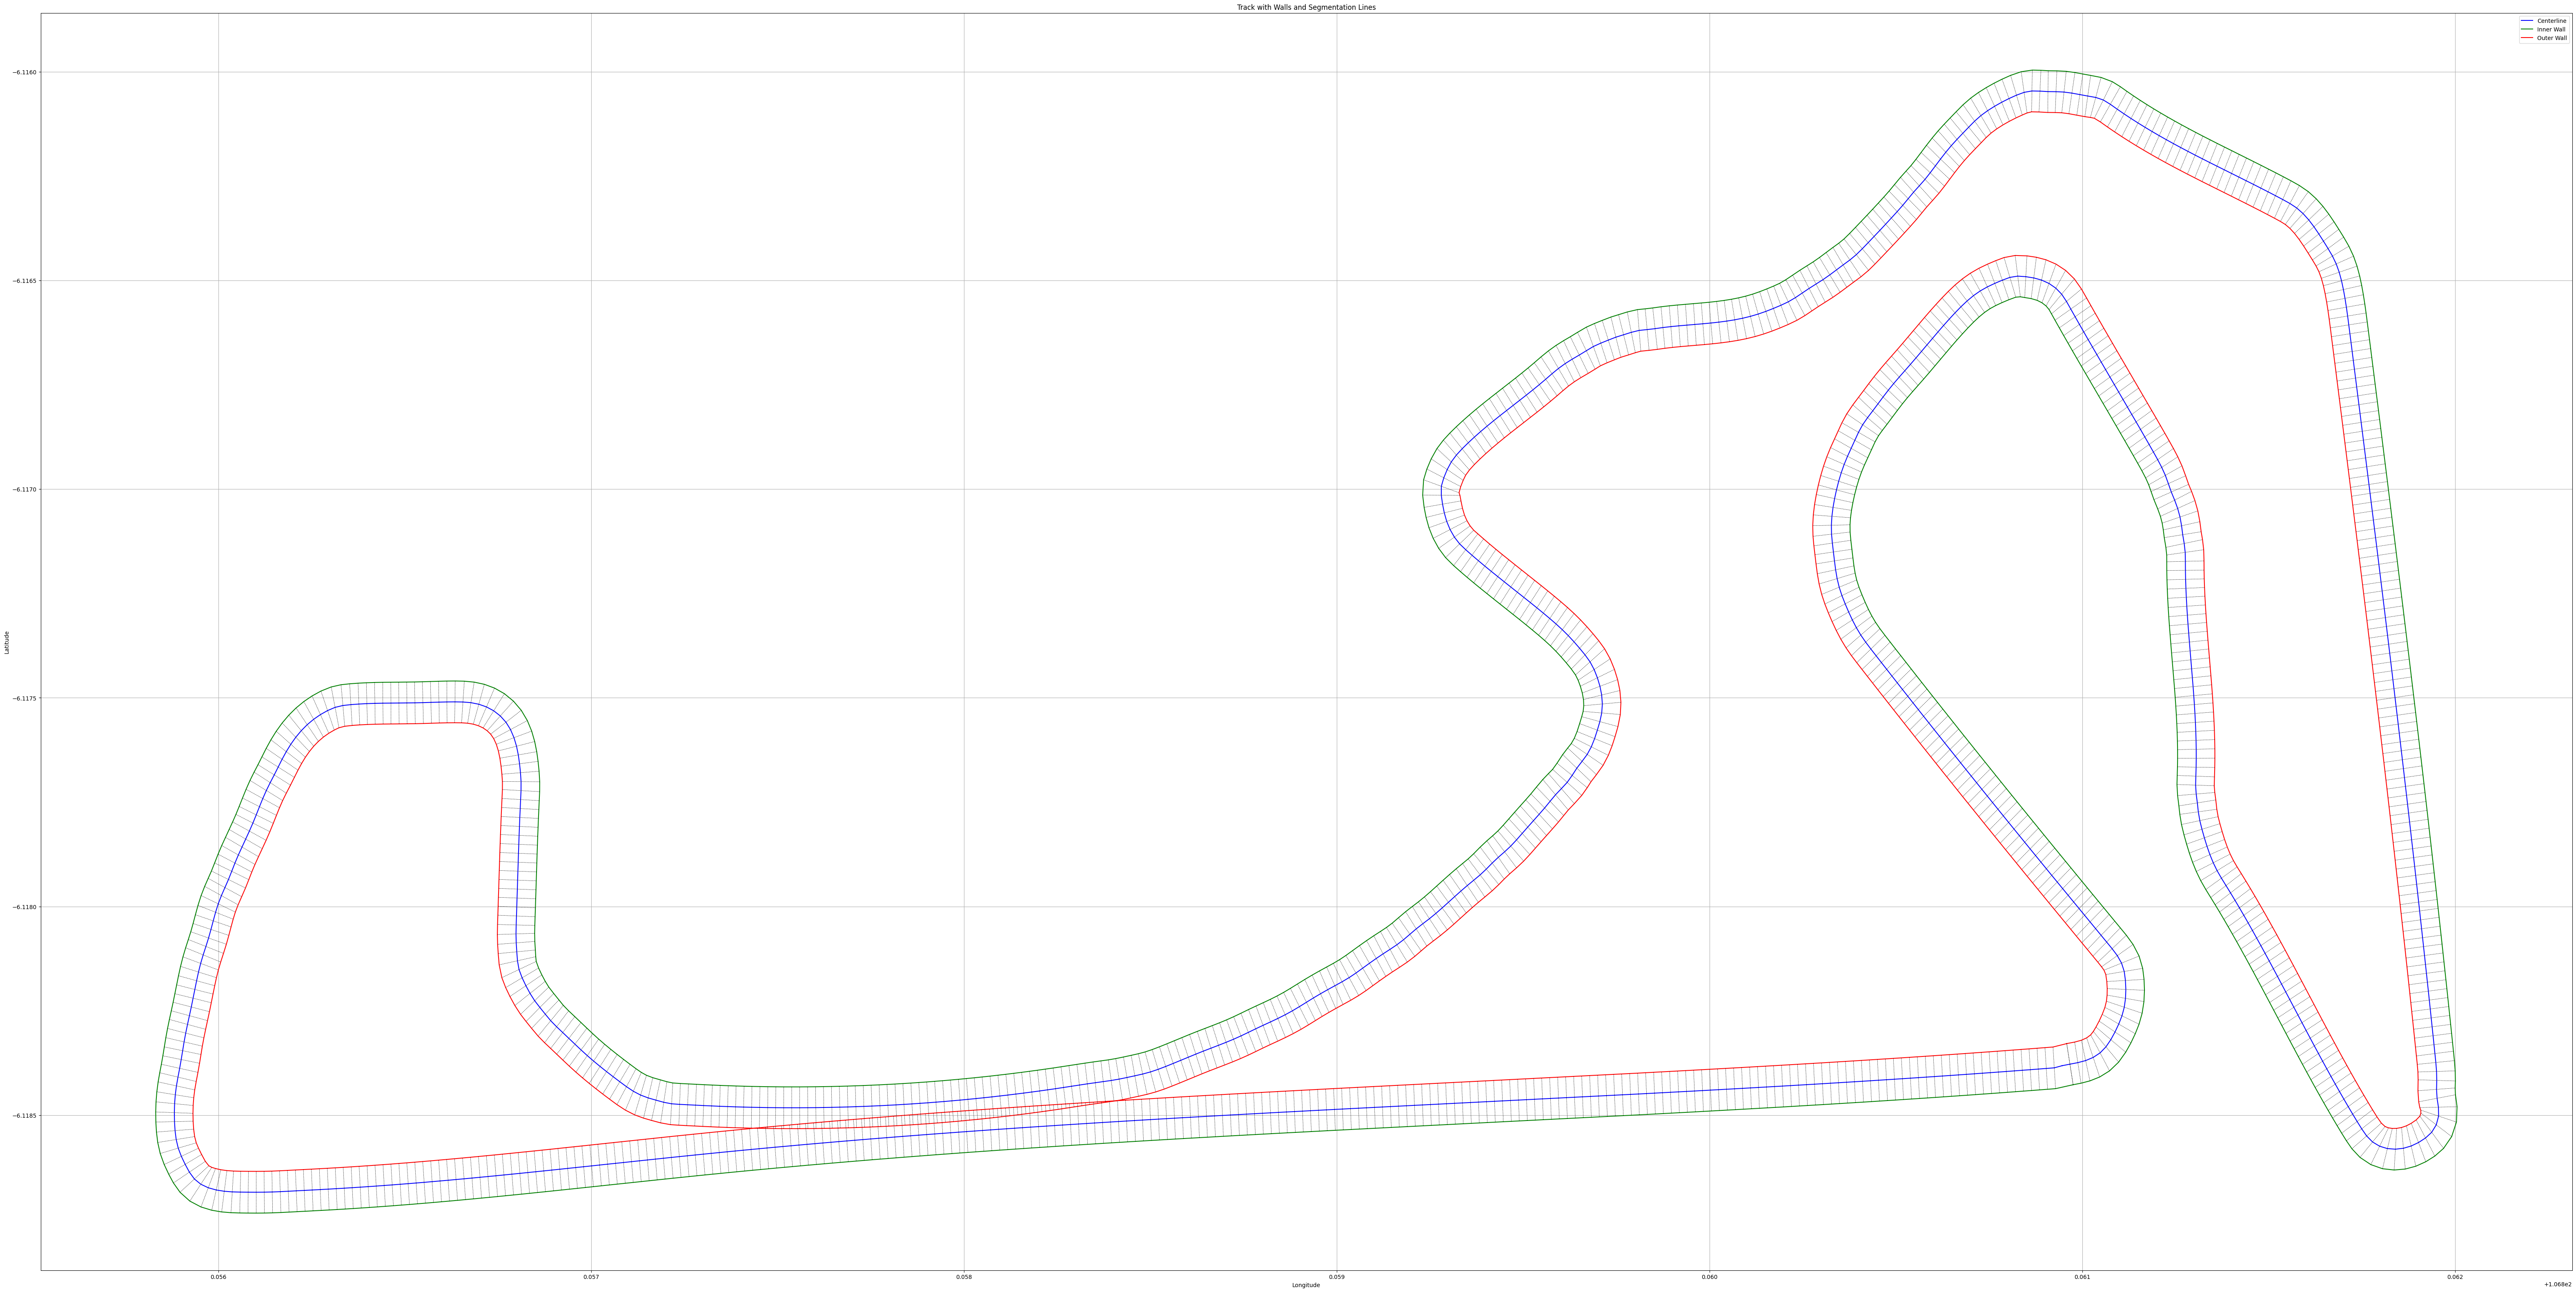

In [55]:
def plot_track_with_segmentation(csv_file, num_segments=10):
    # Load the CSV file
    data = pd.read_csv(csv_file)
    # Extract columns
    tn_long = data['tn-long'].values
    tn_lat = data['tn-lat'].values
    inner_long = data['inner-long'].values
    inner_lat = data['inner-lat'].values
    outer_long = data['outer-long'].values
    outer_lat = data['outer-lat'].values
    # Ensure the track is closed by appending the first point to the end
    tn_long = np.append(tn_long, tn_long[0])
    tn_lat = np.append(tn_lat, tn_lat[0])
    inner_long = np.append(inner_long, inner_long[0])
    inner_lat = np.append(inner_lat, inner_lat[0])
    outer_long = np.append(outer_long, outer_long[0])
    outer_lat = np.append(outer_lat, outer_lat[0])
    # Plot the track
    plt.figure(figsize=(80, 40))
    plt.plot(tn_long, tn_lat, '-', label='Centerline', color='blue')
    plt.plot(inner_long, inner_lat, '-', label='Inner Wall', color='green')
    plt.plot(outer_long, outer_lat, '-', label='Outer Wall', color='red')
    # Add segmentation lines
    for i in range(len(inner_long) - 1):
        seg_long = np.linspace(inner_long[i], outer_long[i], num_segments)
        seg_lat = np.linspace(inner_lat[i], outer_lat[i], num_segments)
        plt.plot(seg_long, seg_lat, '--', color='black', linewidth=0.5)
    # Customize plot
    plt.title('Track with Walls and Segmentation Lines')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid()
    plt.show()
# Example usage
plot_track_with_segmentation('final-track-shape.csv')


No valid solution: p=0.9999837286234088, s=-2.0831376820818936e-13, x1=1.0003604827208419, x2=9600901645641.521
No valid solution: p=0.999999070769841, s=6.899365978407054e-12, x1=1.0000005777086665, x2=-289881708879.6709
No valid solution: p=0.9999979204672999, s=1.987952832895195e-12, x1=1.0000062954202953, x2=-1006060086993.738
No valid solution: p=7.248293131811856e-06, s=3.8136114523843546e-12, x1=-1.000001215961069, x2=-524437275524.16016
No valid solution: p=1.1037460853624559e-05, s=2.9205388966611175e-13, x1=-1.0001567796711055, x2=-6848051235633.915
No valid solution: p=1.974795539549934e-05, s=1.906137797110191e-12, x1=-1.000002158222111, x2=-1049242086815.6559
No valid solution: p=0.9999638882879552, s=-4.822558329133119e-13, x1=1.0000519412771118, x2=4147176381294.3423
No valid solution: p=2.283008624370808e-07, s=6.401687093861832e-11, x1=-1.0000004991059348, x2=-31241764406.97414
Path 1: [np.float64(0.0004642127316030269), np.float64(-0.9609392031490348), np.float64(-0.0

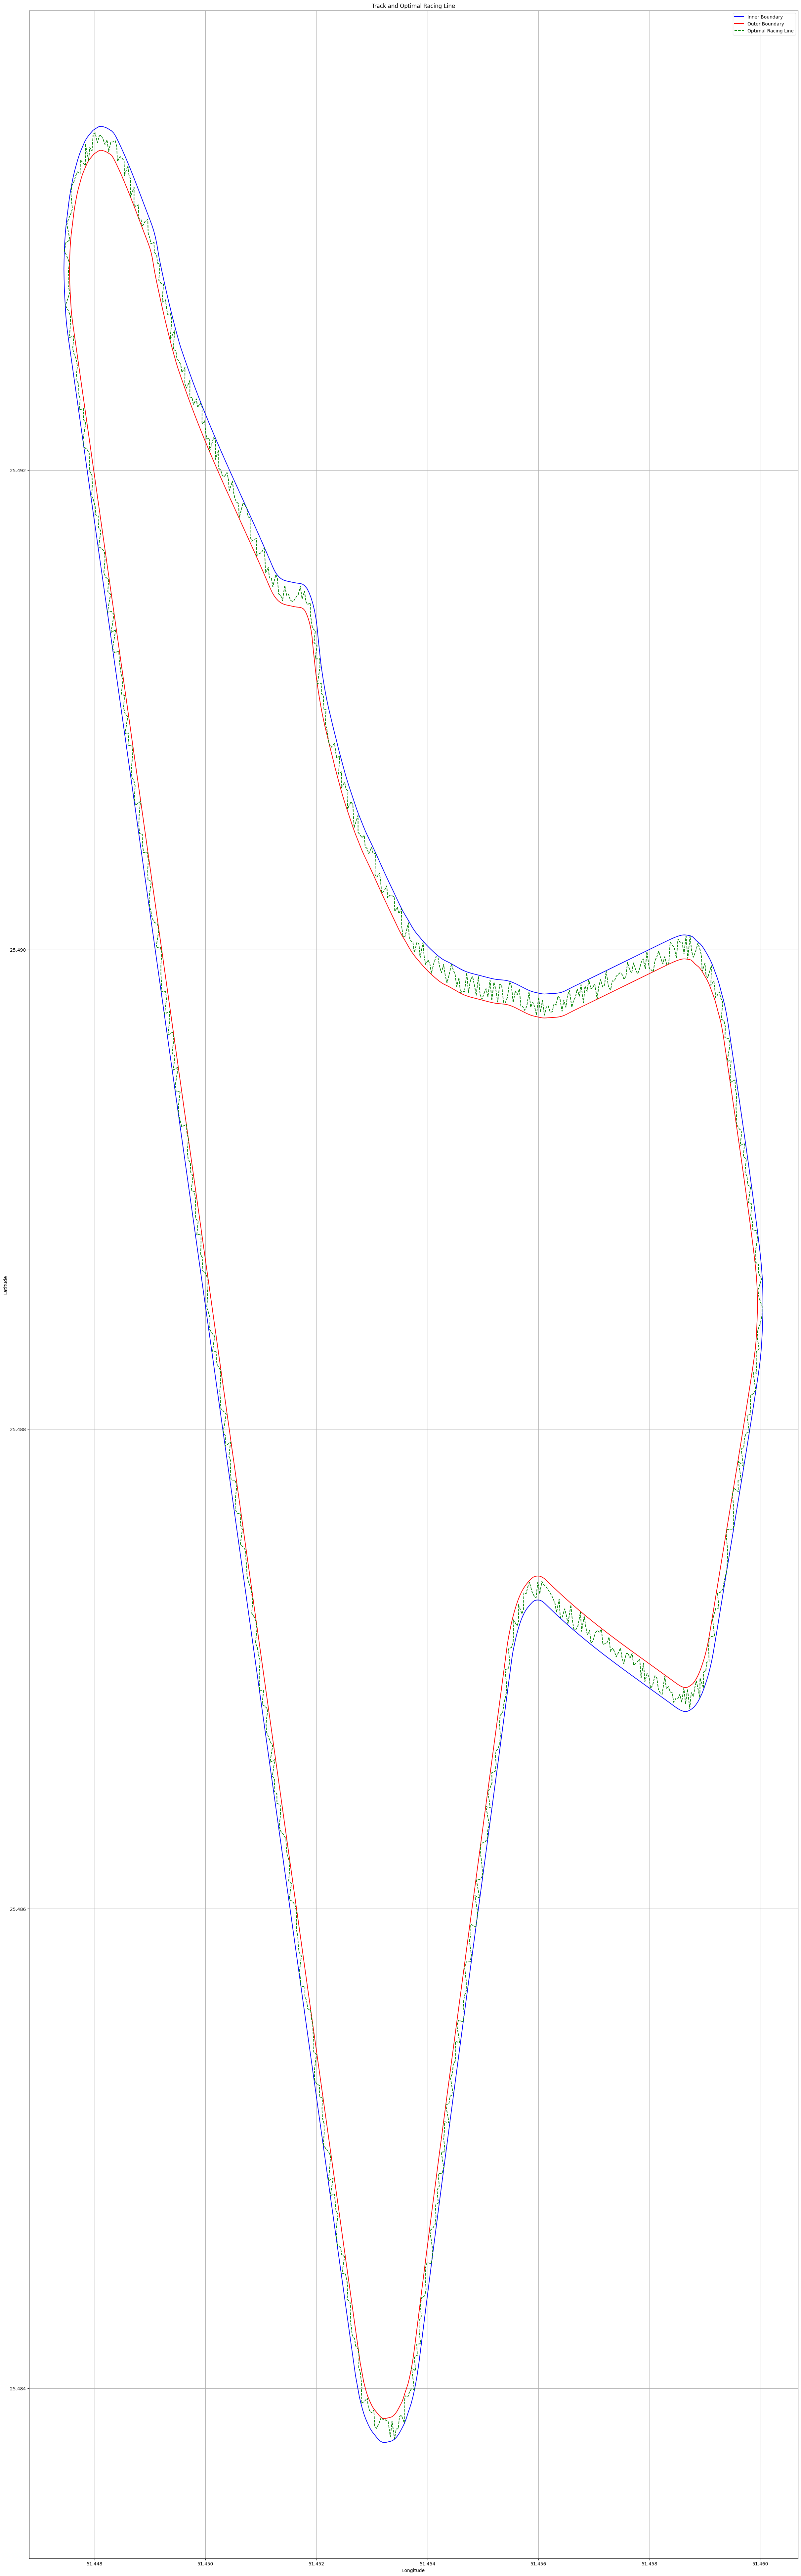

In [ ]:
import numpy as np
from scipy.integrate import quad
from numpy.random import random
import csv
import matplotlib.pyplot as plt

# Define the probability distribution function (PDF) and its integral
def pdf(x, s):
    return 0.5 + 0.5 * s * x

def cdf(x, s):
    return 0.5 * x + 0.5 * s * x**2 / 2

# Solve the quadratic equation: sx^2 + 2x + (2 - s - 4p) = 0
def solve_for_x(p, s):
    a = s
    b = 2
    c = 2 - s - 4 * p

    # Solve using the quadratic formula
    discriminant = b**2 - 4 * a * c
    if discriminant < 0:
        print(f"Discriminant < 0: p={p}, s={s}, discriminant={discriminant}")
        return 0  # Default value or handle the case differently

    x1 = (-b + np.sqrt(discriminant)) / (2 * a)
    x2 = (-b - np.sqrt(discriminant)) / (2 * a)

    # Choose the valid root within the range [-1, 1]
    if -1 <= x1 <= 1:
        return x1
    elif -1 <= x2 <= 1:
        return x2
    else:
        print(f"No valid solution: p={p}, s={s}, x1={x1}, x2={x2}")
        return 0  # Default value or handle the case differently

# Function to evaluate path
def evaluate_path(path, curvature):
    # Ensure velocities are non-zero by adding a small epsilon
    epsilon = 1e-6  # Small constant to avoid division by zero
    time_cost = np.sum([1 / (v + epsilon) for v in path])  # Avoid division by zero
    energy_cost = np.sum(np.sqrt(curvature))   # Placeholder for \int \sqrt{k} ds
    return time_cost, energy_cost

# Main function following the flowchart
def find_optimal_racing_line(curvature_data, max_iter=100):
    best_paths = []

    for iteration in range(max_iter):
        # Step 1: Generate random path using PDF and CDF
        random_path = []
        for segment in curvature_data:
            k1, k2, max_k = segment
            s = min(max((k2 - k1) / max_k, -1), 1)  # Calculate s
            p = random()  # Random number in [0, 1]
            try:
                x = solve_for_x(p, s)  # Solve for x using the quadratic equation
            except ValueError as e:
                print(f"Error in segment: {segment}, {e}")
                x = 0  # Add default value for invalid segments
            random_path.append(x)

        # Step 2: Evaluate path
        curvature = [segment[2] for segment in curvature_data]  # Example curvature data
        t, E = evaluate_path(random_path, curvature)

        # Step 3: Insert path into the list according to t and E
        best_paths.append((random_path, t, E))
        best_paths.sort(key=lambda x: (x[1], x[2]))  # Sort by time cost and energy cost

        # Keep only the top results
        best_paths = best_paths[:10]  # Keep the top 10 paths

    # Return the best paths based on t and E
    return best_paths

# Load track data from a CSV file
def load_track_data(filename):
    track_data = []
    curvature_data = []
    with open(filename, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            tn_long = float(row['tn-long'])
            tn_lat = float(row['tn-lat'])
            inner_long = float(row['inner-long'])
            inner_lat = float(row['inner-lat'])
            outer_long = float(row['outer-long'])
            outer_lat = float(row['outer-lat'])

            # Calculate curvature (placeholder values used here)
            k1 = np.hypot(inner_long - tn_long, inner_lat - tn_lat)
            k2 = np.hypot(outer_long - tn_long, outer_lat - tn_lat)
            max_k = max(k1, k2)

            track_data.append(row)
            curvature_data.append((k1, k2, max_k))
    return track_data, curvature_data

# Plot the track and racing line
def plot_track_and_racing_line(track_data, optimal_path):
    tn_coords = [(float(row['tn-long']), float(row['tn-lat'])) for row in track_data]
    inner_coords = [(float(row['inner-long']), float(row['inner-lat'])) for row in track_data]
    outer_coords = [(float(row['outer-long']), float(row['outer-lat'])) for row in track_data]

    tn_longs, tn_lats = zip(*tn_coords)
    inner_longs, inner_lats = zip(*inner_coords)
    outer_longs, outer_lats = zip(*outer_coords)

    plt.figure(figsize=(30, 100))
    plt.plot(inner_longs, inner_lats, label='Inner Boundary', color='blue')
    plt.plot(outer_longs, outer_lats, label='Outer Boundary', color='red')

    # Plot optimal path
    racing_line_longs = [inner_long + (outer_long - inner_long) * (0.5 + 0.5 * val) for val, (inner_long, outer_long) in zip(optimal_path, zip(inner_longs, outer_longs))]
    racing_line_lats = [inner_lat + (outer_lat - inner_lat) * (0.5 + 0.5 * val) for val, (inner_lat, outer_lat) in zip(optimal_path, zip(inner_lats, outer_lats))]

    plt.plot(racing_line_longs, racing_line_lats, label='Optimal Racing Line', color='green', linestyle='--')
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Track and Optimal Racing Line')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage
track_data, curvature_data = load_track_data("final-track-shape.csv")

# Find the optimal racing line
optimal_paths = find_optimal_racing_line(curvature_data, max_iter=5000)  # Example with 200 iterations

# Display the results
for i, (path, t, E) in enumerate(optimal_paths):
    print(f"Path {i + 1}: {path}, Time Cost: {t:.3f}, Energy Cost: {E:.3f}")

# Plot the track and the best racing line
if optimal_paths:
    best_path = optimal_paths[0][0]  # Take the best path
    plot_track_and_racing_line(track_data, best_path)


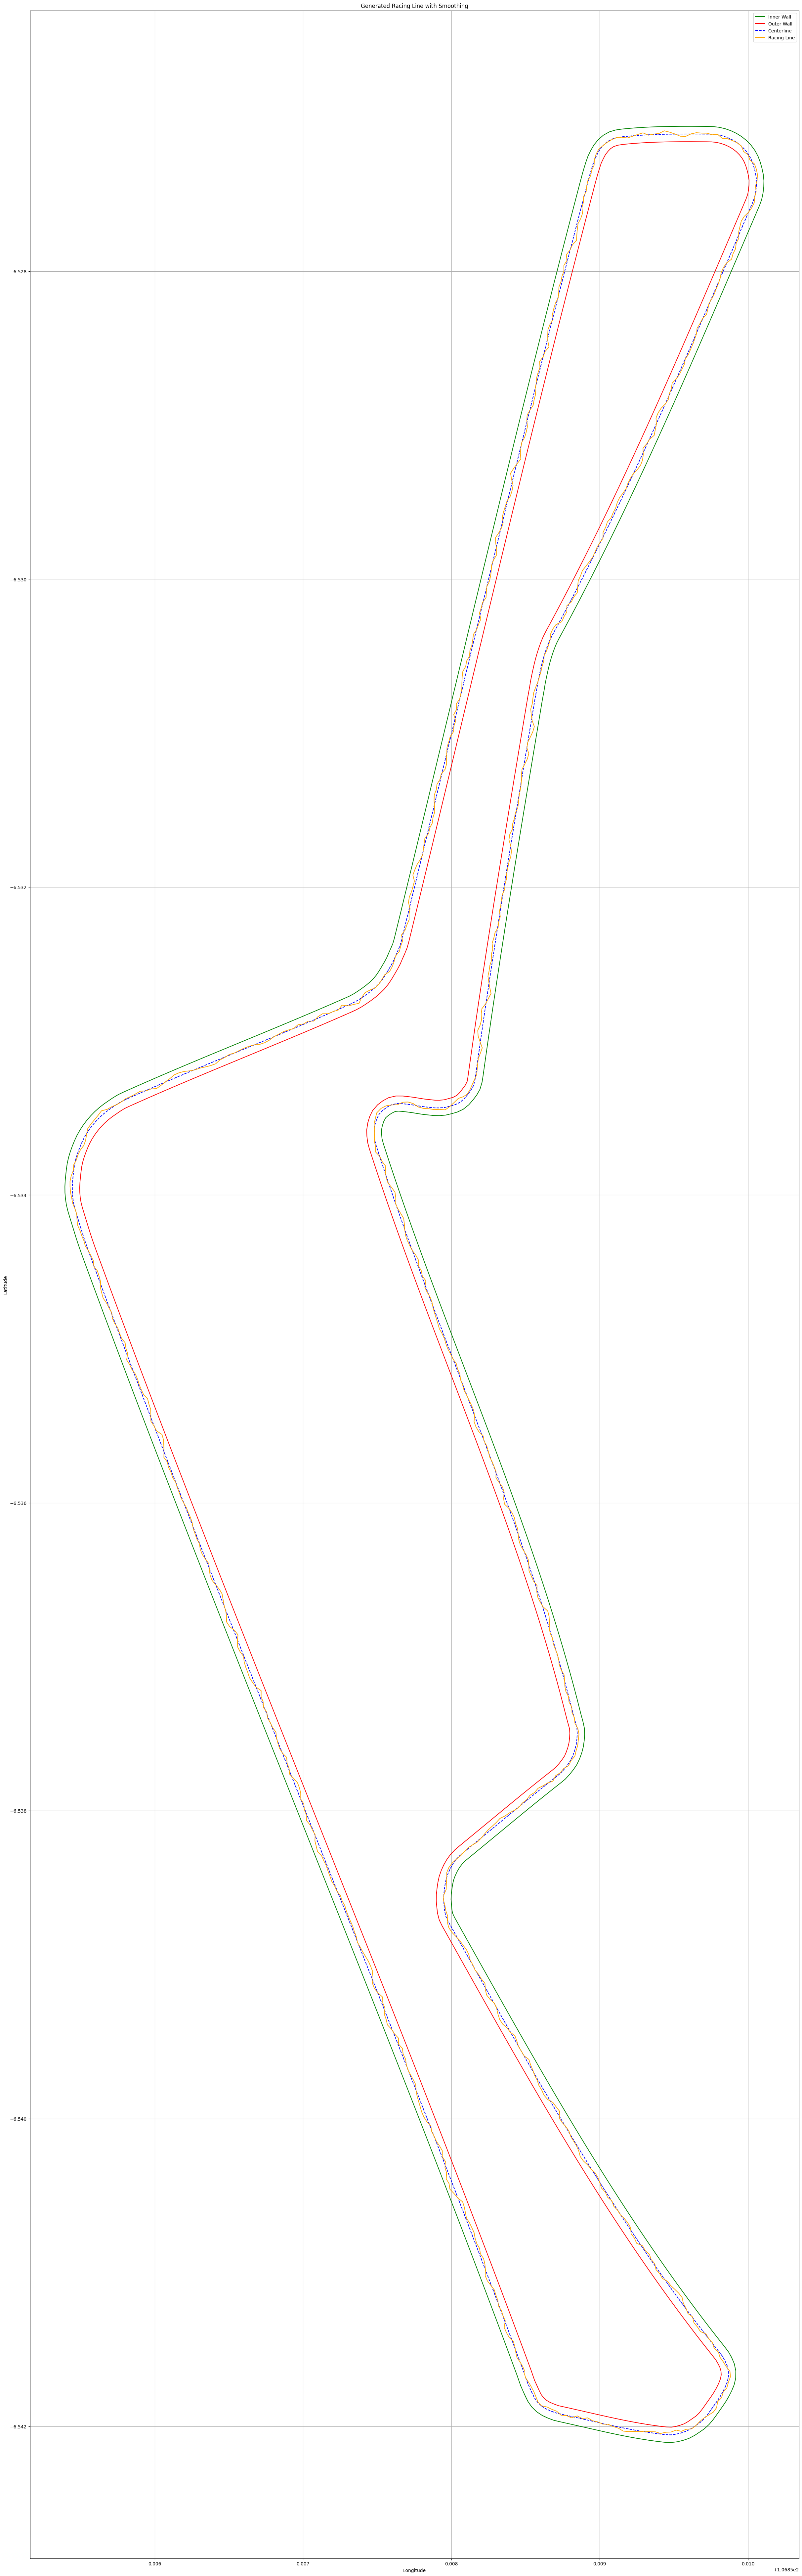

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

def generate_racing_line_with_smoothing(csv_file, iterations=10, bias_towards='center'):
    # Load the track data
    data = pd.read_csv(csv_file)
    
    tn_long = data['tn-long'].values
    tn_lat = data['tn-lat'].values
    inner_long = data['inner-long'].values
    inner_lat = data['inner-lat'].values
    outer_long = data['outer-long'].values
    outer_lat = data['outer-lat'].values

    # Initialize racing line at the centerline
    racing_long = np.copy(tn_long)
    racing_lat = np.copy(tn_lat)

    # Define the PDF center and scale
    if bias_towards == 'inner':
        center = 0  # Closer to the inner wall
    elif bias_towards == 'outer':
        center = 1  # Closer to the outer wall
    else:  # Center
        center = 0.5  # Middle of the track

    scale = 0.2  # Spread of the probability distribution (smaller = tighter)

    # Iteratively adjust racing line points
    for _ in range(iterations):
        for i in range(1, len(tn_long) - 1):  # Skip the first and last points
            # Compute direction vector (dx, dy)
            dx = tn_long[i + 1] - tn_long[i - 1]
            dy = tn_lat[i + 1] - tn_lat[i - 1]
            norm_factor = np.sqrt(dx**2 + dy**2)

            # Normalize direction vector
            dx /= norm_factor
            dy /= norm_factor

            # Perpendicular vector
            perp_dx = -dy
            perp_dy = dx

            # Generate a random point on the perpendicular line
            pdf_values = norm.pdf(np.linspace(0, 1, 100), loc=center, scale=scale)
            probability_sample = pdf_values / pdf_values.sum()  # Normalize PDF
            random_point = np.random.choice(np.linspace(0, 1, 100), p=probability_sample)

            # Interpolate position along the perpendicular line
            racing_long[i] = inner_long[i] * (1 - random_point) + outer_long[i] * random_point
            racing_lat[i] = inner_lat[i] * (1 - random_point) + outer_lat[i] * random_point

        # Smooth the racing line using a weighted average
        smoothed_long = np.copy(racing_long)
        smoothed_lat = np.copy(racing_lat)
        for i in range(1, len(racing_long) - 1):  # Skip the first and last points
            smoothed_long[i] = (racing_long[i - 1] + racing_long[i] + racing_long[i + 1]) / 3
            smoothed_lat[i] = (racing_lat[i - 1] + racing_lat[i] + racing_lat[i + 1]) / 3

        # Update the racing line with smoothed values
        racing_long = smoothed_long
        racing_lat = smoothed_lat

    # Close the loop
    racing_long = np.append(racing_long, racing_long[0])
    racing_lat = np.append(racing_lat, racing_lat[0])

    # Add racing line to DataFrame
    racing_line_data = pd.DataFrame({
        'racing-long': racing_long,
        'racing-lat': racing_lat
    })

    # Plot for visualization
    plt.figure(figsize=(30, 100))
    plt.plot(inner_long, inner_lat, '-', label='Inner Wall', color='green')
    plt.plot(outer_long, outer_lat, '-', label='Outer Wall', color='red')
    plt.plot(tn_long, tn_lat, '--', label='Centerline', color='blue')
    plt.plot(racing_long, racing_lat, '-', label='Racing Line', color='orange')
    plt.title('Generated Racing Line with Smoothing')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid()
    plt.show()

    return racing_line_data


# Example usage
racing_line_df = generate_racing_line_with_smoothing('final-track-shape.csv', iterations=100, bias_towards='center')
